In [37]:
import random
import numpy as np
import pandas as pd
import math
from scipy import stats
import pycaret
import gower
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
# import umap
import umap.umap_ as umap
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import StandardScaler
from pycaret.clustering import *
from category_encoders.backward_difference import BackwardDifferenceEncoder
from transformers import RobertaForMaskedLM, RobertaTokenizer, pipeline
from category_encoders import HelmertEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import gridspec
import matplotlib.pyplot as plt
import plotnine as p9
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

In [3]:
# TODO: поменять на от руки написанный 
# https://github.com/scikit-learn-contrib/scikit-learn-extra/blob/main/sklearn_extra/utils/_cyfht.pyx
# from sklearn_extra.cluster import KMedoids

In [5]:
dataset = pd.read_csv('embeddings.csv')
dataset.sample()

,MATCHED_VARIABLE_NAME_mean,EVENT_ID_mean,variable_src_in_name,MATCHED_VARIABLE_SRC_std,EVENT_ID_median,MATCHED_VARIABLE_NAME_sum,MATCHED_VARIABLE_NAME_min,MATCHED_VARIABLE_NAME_max,RESPONSE_CODE,CLIENT_IP,EVENT_ID_max,MATCHED_VARIABLE_VALUE_mean,MATCHED_VARIABLE_SRC_mean,MATCHED_VARIABLE_NAME_std,MATCHED_VARIABLE_VALUE_min,MATCHED_VARIABLE_SRC_mode,MATCHED_VARIABLE_NAME_mode,MATCHED_VARIABLE_VALUE_std,bad_req_size,random_feature,MATCHED_VARIABLE_NAME_count,EVENT_ID_count,EVENT_ID_min,MATCHED_VARIABLE_VALUE_sum,MATCHED_VARIABLE_SRC_max,MATCHED_VARIABLE_SRC_sum,MATCHED_VARIABLE_SRC_median,MATCHED_VARIABLE_NAME_median,var_name_eql_value,MATCHED_VARIABLE_VALUE_median,EVENT_ID_std,bad_resp_code,MATCHED_VARIABLE_VALUE_count,MATCHED_VARIABLE_VALUE_mode,MATCHED_VARIABLE_SRC_count,MATCHED_VARIABLE_VALUE_max,EVENT_ID_mode,CLIENT_USERAGENT_count,EVENT_ID_sum,REQUEST_SIZE,MATCHED_VARIABLE_SRC_min,CLIENT_IP.1
36832,5388.8125,55.3,1,14981.440245,59.0,86221,18,45604,404,94.180.182.133,93,6482.0,6152.571429,14158.795033,29,43,67,5399.180012,0,30931,11165,1,21,32410,45604,86136,54.5,54.5,0,6741.0,20.075109,0,1,29,20812,14370,59,23,1106,908,37,94.180.182.133


In [8]:
dataset.columns

Index(['MATCHED_VARIABLE_NAME_mean', 'EVENT_ID_mean', 'variable_src_in_name',
       'MATCHED_VARIABLE_SRC_std', 'EVENT_ID_median',
       'MATCHED_VARIABLE_NAME_sum', 'MATCHED_VARIABLE_NAME_min',
       'MATCHED_VARIABLE_NAME_max', 'RESPONSE_CODE', 'CLIENT_IP',
       'EVENT_ID_max', 'MATCHED_VARIABLE_VALUE_mean',
       'MATCHED_VARIABLE_SRC_mean', 'MATCHED_VARIABLE_NAME_std',
       'MATCHED_VARIABLE_VALUE_min', 'MATCHED_VARIABLE_SRC_mode',
       'MATCHED_VARIABLE_NAME_mode', 'MATCHED_VARIABLE_VALUE_std',
       'bad_req_size', 'random_feature', 'MATCHED_VARIABLE_NAME_count',
       'EVENT_ID_count', 'EVENT_ID_min', 'MATCHED_VARIABLE_VALUE_sum',
       'MATCHED_VARIABLE_SRC_max', 'MATCHED_VARIABLE_SRC_sum',
       'MATCHED_VARIABLE_SRC_median', 'MATCHED_VARIABLE_NAME_median',
       'var_name_eql_value', 'MATCHED_VARIABLE_VALUE_median', 'EVENT_ID_std',
       'bad_resp_code', 'MATCHED_VARIABLE_VALUE_count',
       'MATCHED_VARIABLE_VALUE_mode', 'MATCHED_VARIABLE_SRC_count',
       

In [10]:
dataset.drop(['CLIENT_IP', 'CLIENT_IP.1'], axis=1, inplace=True)

In [11]:
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)
dataset.shape

(57829, 40)

In [13]:
%%time
embedding = umap.UMAP(random_state=12).fit(dataset)
umap_embedding = embedding.embedding_


results = pd.DataFrame(
                        {'x': umap_embedding[:,0],
                         'y':  umap_embedding[:,1],
                        })

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 2min 53s, sys: 1.19 s, total: 2min 55s
Wall time: 1min 3s


### Dimensionality Reduction with UMAP

In [18]:
UMAP_2D_data

array([[-1.57479743, -0.71262148, -1.6245319 , ..., -0.72557099,
        -0.05008009,  0.7152478 ],
       [-1.12462861, -0.60648441, -1.6245319 , ..., -0.61499085,
        -0.04772125, -0.05966736],
       [-1.57479743,  0.04701615, -1.6245319 , ...,  0.08405441,
        -0.0480417 ,  0.7152478 ],
       ...,
       [-0.27565573,  0.53028319,  0.61556193, ...,  0.60100198,
        -0.03862416,  0.32779022],
       [-0.58705159,  0.82728348,  0.61556193, ...,  0.91870124,
        -0.03776073, -0.05966736],
       [-1.23885264, -0.71132702, -1.6245319 , ..., -0.72411343,
         0.80146876, -0.05966736]])

In [19]:
# UMAP_2D_data = dataset.copy()
UMAP_2D_data = pd.DataFrame()
UMAP_2D_data['x'] = umap_embedding[:,0]
UMAP_2D_data['y'] = umap_embedding[:,1]

In [24]:
num_clusters = 32
random_state = 32


dbscan_clusterer = DBSCAN(eps=0.3, min_samples=10).fit(umap_embedding)

kmeans_clusterer = KMeans(n_clusters=num_clusters, init='k-means++',
                        verbose=0, random_state=random_state,
                        algorithm='auto').fit(umap_embedding)

UMAP_2D_data["kmeans_preds"] = kmeans_clusterer.labels_
UMAP_2D_data["dbscan_preds"] = dbscan_clusterer.labels_

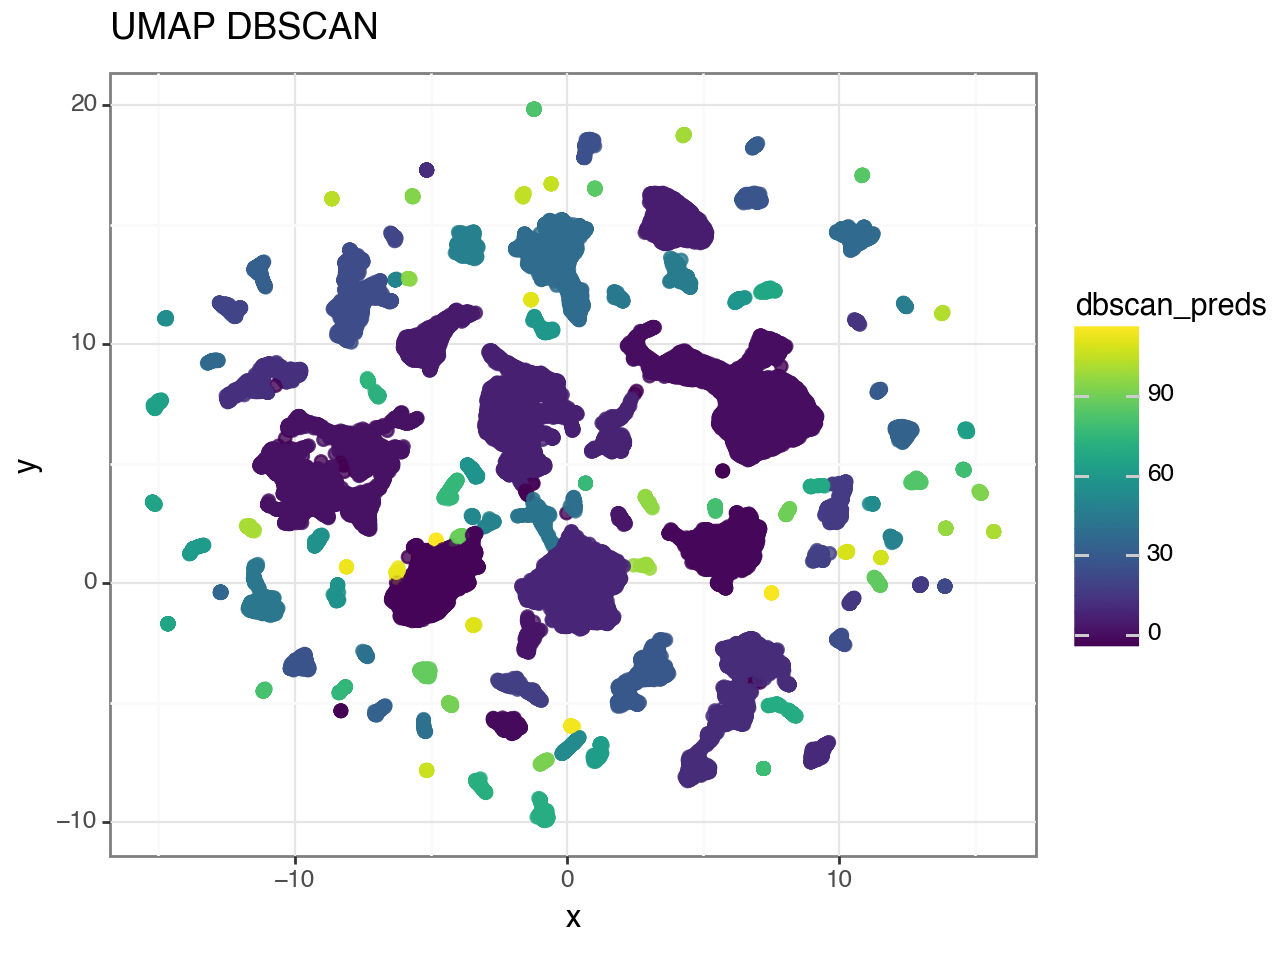

<Figure Size: (640 x 480)>

In [22]:
dbscan_plot = (p9.ggplot(UMAP_2D_data, p9.aes(x='x', y='y', fill='dbscan_preds', color='dbscan_preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('UMAP DBSCAN')
      + p9.theme_bw())

kmeans_plot = (p9.ggplot(UMAP_2D_data, p9.aes(x='x', y='y', fill='kmeans_preds', color='kmeans_preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle(f'UMAP Kmeans num_clusters {num_clusters}')
      + p9.theme_bw())

dbscan_plot

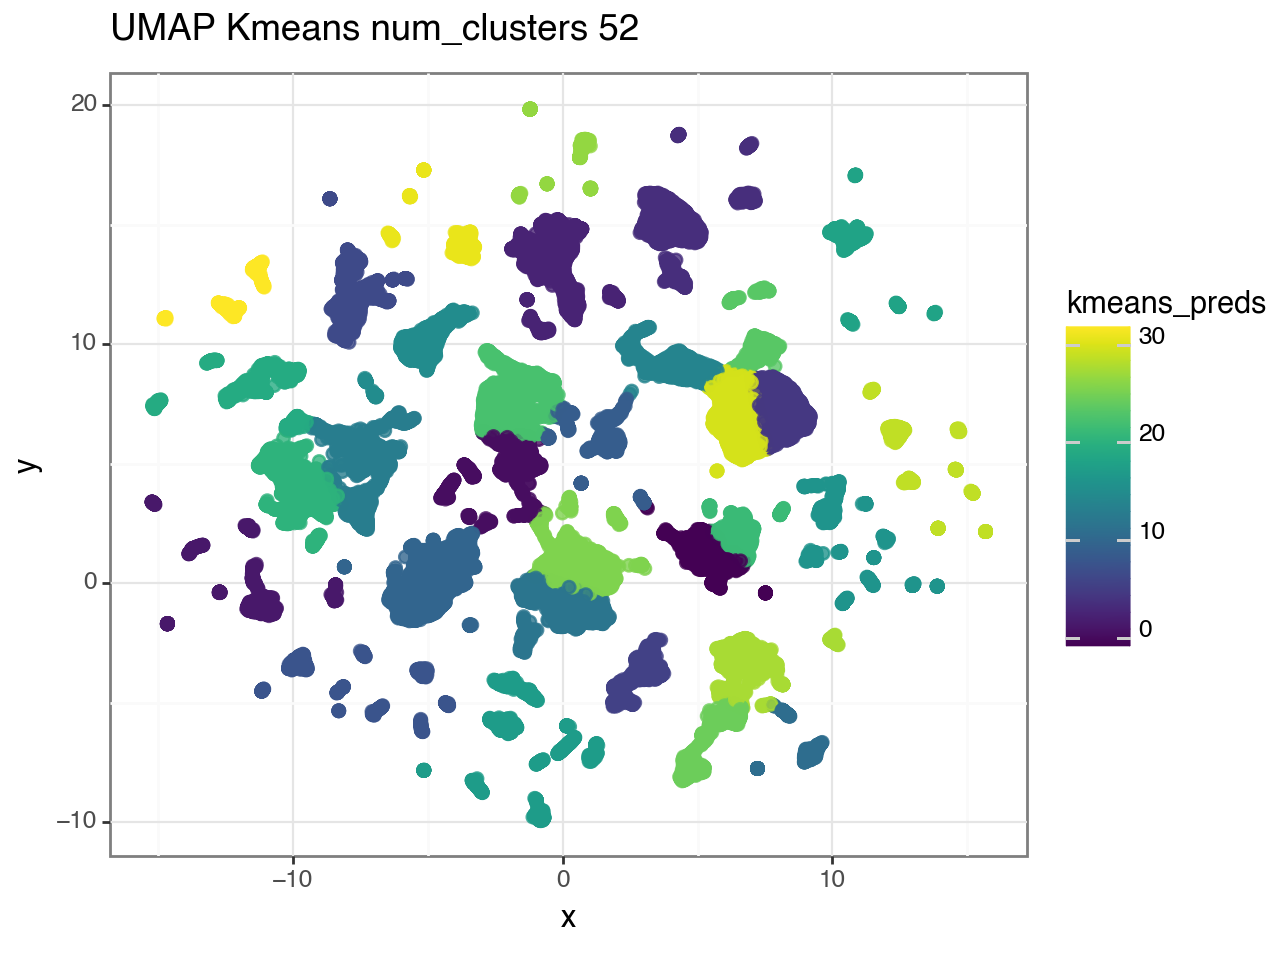

<Figure Size: (640 x 480)>

In [25]:
kmeans_plot

### Gower Distance

In [24]:
def calculate_gower_distance(df):
  
  '''
  Takes a dataframe as an input and returns the gower distance
  matrix.
  
  '''

  variable_distances = []
  
  for col in range(df.shape[1]):
    
    feature = df.iloc[:,[col]]
    if feature.dtypes.values == object:
      
      feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature, drop_first=True))
        
    else:
      
      feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / max(np.ptp(feature.values),1)


      variable_distances.append(feature_dist)
      

  return np.array(variable_distances).mean(0)

In [ ]:
%%time 
gower_data = dataset.copy()
gower_distance_matrix = calculate_gower_distance(gower_data)

In [ ]:
umap_embeddings = umap.UMAP(random_state=42, n_components=2).fit_transform(gower_distance_matrix)

gower_data['x'] = umap_embeddings[:,0]
gower_data['y'] = umap_embeddings[:,1]

# gower_data['target'] = labels


gower_clusterer = KMedoids(n_clusters=num_clusters, metric='precomputed',
                           method='pam', init='build', 
                           max_iter=300, random_state=random_state).fit(gower_distance_matrix)


gower_data["preds"] = gower_clusterer.labels_
gower_data["preds"] = gower_data["preds"].apply(str)

predictions['gower_preds'] = gower_clusterer.labels_

In [ ]:
p1_gower_d = (p9.ggplot(gower_data, p9.aes(x='x', y='y', fill='target', color='target'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Bank Data Gower Matrix UMAP 2D Ground Truth')
      + p9.theme_bw())

p2_gower_d = (p9.ggplot(gower_data, p9.aes(x='x', y='y', fill='preds', color='preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Bank Data Gower Matrix UMAP 2D KMedoids')
      + p9.theme_bw())

p1_gower_d

In [ ]:
p2_gower_d

### FAMD

In [38]:
def calculate_zscore(df, columns):
  '''
  scales columns in dataframe using z-score
  '''
  df = df.copy()
  for col in columns:
      df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

  return df



def one_hot_encode(df, columns):
  '''
  one hot encodes list of columns and
  concatenates them to the original df
  '''

  concat_df = pd.concat([pd.get_dummies(df[col], drop_first=True, prefix=col) for col in columns], axis=1)
  one_hot_cols = concat_df.columns

  return concat_df, one_hot_cols



def normalize_column_modality(df, columns):
  '''
  divides each column by the probability μₘ of the modality 
  (number of ones in the column divided by N) only for one hot columns
  '''

  length = len(df)
  for col in columns:
    
    weight = math.sqrt(sum(df[col])/length)
    df[col] = df[col]/weight

  return df



def center_columns(df, columns):
  '''
  center columns by subtracting the mean value
  '''
  for col in columns:
      df[col] = (df[col] - df[col].mean())

  return df



def FAMD_(data, n_components=2):
  '''
  Factorial Analysis of Mixed Data (FAMD), 
  which generalizes the Principal Component Analysis (PCA) 
  algorithm to datasets containing numerical and categorical variables

  a) For the numerical variables
    - Standard scale (= get the z-score)
  
  b) For the categorical variables:
    - Get the one-hot encoded columns
    - Divide each column by the square root of its probability sqrt(μₘ)
    - Center the columns

  c) Apply a PCA algorithm over the table obtained!

  '''
  
  variable_distances = []

  numeric_cols = data.select_dtypes(include=np.number)
  cat_cols = data.select_dtypes(include='object')
  
  print('numeric process')
  normalized_df = calculate_zscore(data, numeric_cols)
  normalized_df = normalized_df[numeric_cols.columns]

  print('categorical process')
  print('one_hot_encode')
  cat_one_hot_df, one_hot_cols = one_hot_encode(data, cat_cols)
  print('normalize_column_modality')
  cat_one_hot_norm_df = normalize_column_modality(cat_one_hot_df, one_hot_cols)
  print('center_columns')
  cat_one_hot_norm_center_df = center_columns(cat_one_hot_norm_df, one_hot_cols)

  print('Merge DataFrames')
  processed_df = pd.concat([normalized_df, cat_one_hot_norm_center_df], axis=1)

  print('Perform (PCA)')
  pca = PCA(n_components=n_components)
  principalComponents = pca.fit_transform(processed_df)

  return principalComponents

In [29]:
source_dataset = pd.read_csv('../data/part_10.csv')
source_dataset.drop(['CLIENT_IP', 'EVENT_ID'], axis=1, inplace=True)
source_dataset.sample()

,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE
13818,Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7....,244,404,REQUEST_URI,NaN,/rd8.68gkb.log


In [ ]:
# TODO: n_components

In [ ]:
%%time
FAMD_data = source_dataset.copy()
FAMD_components = FAMD_(FAMD_data)

FAMD_data['x'] = FAMD_components[:,0]
FAMD_data['y'] = FAMD_components[:,1]

# FAMD_data['target'] = labels

numeric process
categorical process


In [ ]:
FAMD_dbscan_clusterer = DBSCAN(eps=0.3, min_samples=10).fit(FAMD_components)

FAMD_kmeans_clusterer = KMeans(n_clusters=num_clusters, init='k-means++',
                        verbose=0, random_state=random_state,
                        algorithm='auto').fit(FAMD_components)


FAMD_data["dbscsan_preds"] = FAMD_dbscan_clusterer.labels_
FAMD_data["kmeans_preds"] = FAMD_kmeans_clusterer.labels_

In [ ]:
dbscan_famd = (p9.ggplot(FAMD_data, p9.aes(x='x', y='y', fill='dbscsan_preds', color='dbscsan_preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('FAMD DBSCAN')
      + p9.theme_bw())

kmeans_famd = (p9.ggplot(FAMD_data, p9.aes(x='x', y='y', fill='kmeans_preds', color='kmeans_preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('FAMD Kmeans')
      + p9.theme_bw())

p1_famd

In [33]:
# пока без теста
# X_train, X_test, y_train, y_test = train_test_split(classified, y, test_size=0.2, random_state=42)

In [34]:
# %%time
# bd = BackwardDifferenceEncoder(drop_invariant=True)
# dataset_bd = bd.fit_transform(dataset[cat_features])
# dataset_f = pd.merge(dataset_bd, dataset[num_features], left_index=True, right_index=True)

In [ ]:
# %%time
# he = HelmertEncoder(drop_invariant=True)
# dataset_he = he.fit_transform(dataset[cat_features])
# dataset_f = pd.merge(dataset_he, dataset[num_features], left_index=True, right_index=True)

In [ ]:
# https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering

In [ ]:
# https://github.com/art-glazunov/Non-standard-categorical-encodings/blob/main/group_counts_and_SVD.ipynb

In [8]:
# брать только часть датасета 
df_sample = dataset_transformed.sample(frac=0.25)
dataset_transformed.shape, df_sample.shape

((57845, 41), (14461, 41))

### Goverce distance 

In [ ]:
# https://medium.com/analytics-vidhya/the-ultimate-guide-for-clustering-mixed-data-1eefa0b4743b

In [ ]:
## очень долго считается

%%time
dist_matrix = gower.gower_matrix(df_sample)

In [ ]:


clusters = (KMedoids(n_clusters=num_clusters, 
                           metric='precomputed',
                           method='pam', init='build', 
                           max_iter=300, 
                           random_state=random_state)
            .fit(dist_matrix)
            .labels_)

### pycaret 

In [5]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (54953, 8)
Unseen Data For Predictions: (2892, 8)


In [7]:
exp_clu101 = setup(data, normalize = True, 
                   # ignore_features = ['MouseID'],
                   session_id = 123)

KeyboardInterrupt: 

In [ ]:
# 'dbscan'
kmeans = create_model('kmeans')
print(kmeans)

In [ ]:
kmodes = create_model('kmodes', num_clusters = 6)
print(kmodes)

In [ ]:
models()

In [ ]:
kmean_results = assign_model(kmeans)
kmean_results.head()

In [ ]:
plot_model(kmeans)

In [ ]:
plot_model(kmeans, plot = 'elbow')

In [ ]:
plot_model(kmeans, plot = 'silhouette')

In [ ]:
plot_model(kmeans, plot = 'distribution', feature = 'class')

In [ ]:
unseen_predictions = predict_model(kmeans, data=data_unseen)
unseen_predictions.head()

In [ ]:
save_model(kmeans,’Final KMeans Model 25Nov2020')

In [ ]:
# TODO: посмотреть на метрики - насколько хорошо обучилась модель 